In [110]:
import csv
import os
import urllib.request
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [111]:
url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv'
response = urllib.request.urlretrieve(url, os.path.join(os.getcwd(), 'sunspots.csv'))

In [112]:
time_step = []
sunspots = []

In [113]:
with open('sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

In [114]:
series  = np.array(sunspots)
time = np.array(time_step)

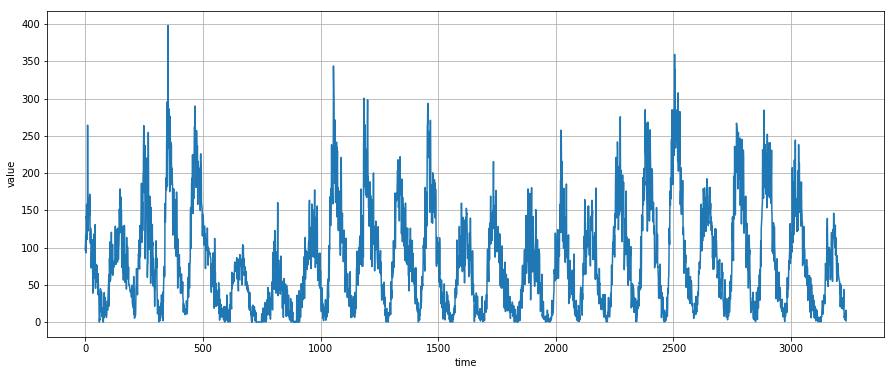

In [115]:
plt.figure(figsize=(15,6))
_ = plt.plot(time, series)
_ = plt.xlabel('time')
_ = plt.ylabel('value')
_ = plt.grid(True)

In [116]:
print(time.shape)
print(series.shape)

(3235,)
(3235,)


In [117]:
split_time = 3000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid  = series[split_time:]

In [118]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [119]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [120]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return  forecast

In [121]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
batch_size = 256

In [122]:
train_set = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)

In [123]:
print(train_set)
print(X_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [85]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, 
                           strides=1, padding='causal',
                           activation='relu', 
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [86]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

In [87]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [89]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=False)

[1e-08, 0.0001, 0, 60]

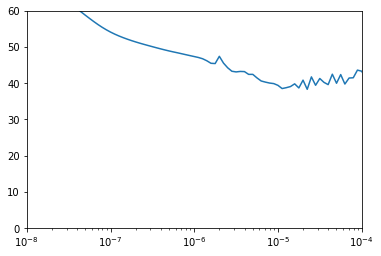

In [92]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])

In [93]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

In [94]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5, 
                           strides=1, padding='causal', 
                           activation='relu', 
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [95]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

In [96]:
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, 
              metrics=['mae'])

In [101]:
history = model.fit(train_set, epochs=500, verbose=False)

In [103]:
rnn_forecast = model_forecast(model, series, window_size)

In [104]:
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

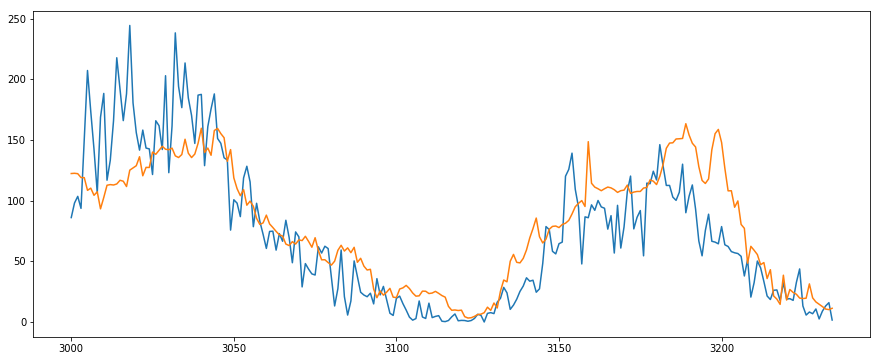

In [105]:
plt.figure(figsize=(15,6))
plt.plot(time_valid, X_valid)
plt.plot(time_valid, rnn_forecast)

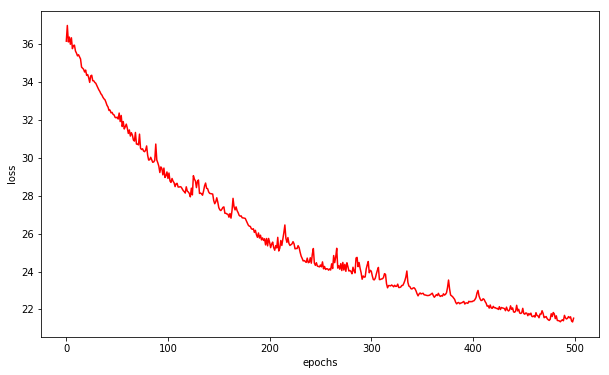

In [107]:
loss = history.history['loss']
epochs = range(len(loss))

plt.figure(figsize=(10,6))
_ = plt.plot(epochs, loss, 'r')
_ = plt.xlabel('epochs')
_ = plt.ylabel('loss')